In [1]:
import calitp
from calitp.tables import tbl
from siuba import *

import pandas as pd
ix = pd.IndexSlice
import numpy as np
import geopandas as gpd

from calenviroscreen_utils import *
from utils import *
import prep_data
import shared_utils

import shapely
from shapely.geometry import LineString

import os
from calitp.storage import get_fs
fs = get_fs()

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
service_funding_joined = pd.read_parquet(f"{GCS_FILE_PATH}shape_frequency_funding.parquet")

In [3]:
service = service_funding_joined >> select(_.calitp_itp_id, _.shape_id, _.day_name, _.departure_hour, _.trips_per_hour, _.mean_runtime_min)

In [4]:
service.head(3)

,calitp_itp_id,shape_id,day_name,departure_hour,trips_per_hour,mean_runtime_min
0,257,13737,Thursday,0,0,NaN
1,257,13737,Thursday,1,0,NaN
2,257,13737,Thursday,2,0,NaN


In [5]:
processed_shapes = gpd.read_parquet(f'{GCS_FILE_PATH}shapes_processed.parquet')

In [6]:
tracts_categorized = processed_shapes >> select(_.calitp_itp_id, _.shape_id, _.tract_type)
tracts_categorized.head(3)

,calitp_itp_id,shape_id,tract_type
0,257,13737,urban
1,257,13738,suburban
2,259,p_110998,suburban


In [7]:
service_tract_type = service >> inner_join(_, tracts_categorized, on = ['calitp_itp_id', 'shape_id'])

In [8]:
service_tract_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392112 entries, 0 to 392111
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   calitp_itp_id     392112 non-null  int64  
 1   shape_id          392112 non-null  object 
 2   day_name          392112 non-null  object 
 3   departure_hour    392112 non-null  int64  
 4   trips_per_hour    392112 non-null  int64  
 5   mean_runtime_min  87861 non-null   float64
 6   tract_type        386856 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 23.9+ MB


In [9]:
service_tract_type = service_tract_type >> filter(_.departure_hour > 4, _.departure_hour < 21) ## filter for performance

In [10]:
service_tract_type.head(3)

,calitp_itp_id,shape_id,day_name,departure_hour,trips_per_hour,mean_runtime_min,tract_type
5,257,13737,Thursday,5,0,NaN,urban
6,257,13737,Thursday,6,4,49.0,urban
7,257,13737,Thursday,7,4,55.0,urban


In [11]:
service_tract_type

,calitp_itp_id,shape_id,day_name,departure_hour,trips_per_hour,mean_runtime_min,tract_type
5,257,13737,Thursday,5,0,NaN,urban
6,257,13737,Thursday,6,4,49.0,urban
7,257,13737,Thursday,7,4,55.0,urban
8,257,13737,Thursday,8,4,59.0,urban
9,257,13737,Thursday,9,2,55.0,urban
...,...,...,...,...,...,...,...
392104,251,p_298772,Sunday,16,0,NaN,urban
392105,251,p_298772,Sunday,17,0,NaN,urban
392106,251,p_298772,Sunday,18,0,NaN,urban
392107,251,p_298772,Sunday,19,0,NaN,urban


In [12]:
min_runtimes = service_tract_type.groupby(['calitp_itp_id', 'shape_id'])[['mean_runtime_min']].min()
min_runtimes = min_runtimes.rename(columns={'mean_runtime_min': 'min_runtime_min'})
min_runtimes.head(3)

min_runtime_min
calitp_itp_id shape_id                  
4             shp-10-09             28.0
              shp-10-10             27.0
              shp-12-13             51.0

In [13]:
service_tract_type = (service_tract_type >> inner_join(_, min_runtimes.reset_index(), on = ['calitp_itp_id', 'shape_id']))

In [14]:
service_tract_type = service_tract_type.dropna(subset=['tract_type', 'min_runtime_min'])

In [15]:
## runtime for analysis is the mean runtime for a shape/day/hour for existing service, or the min runtime for new service
service_tract_type['runtime'] = service_tract_type[['mean_runtime_min', 'min_runtime_min']].max(axis = 1)

In [16]:
service_tract_type = service_tract_type >> select(-_.mean_runtime_min, -_.min_runtime_min)
service_tract_type['runtime'] = service_tract_type['runtime'].astype('int64')

In [17]:
service_tract_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246384 entries, 0 to 261407
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   calitp_itp_id   246384 non-null  int64 
 1   shape_id        246384 non-null  object
 2   day_name        246384 non-null  object
 3   departure_hour  246384 non-null  int64 
 4   trips_per_hour  246384 non-null  int64 
 5   tract_type      246384 non-null  object
 6   runtime         246384 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 15.0+ MB


In [18]:
service_thursday = service_tract_type >> filter(_.day_name == 'Thursday') ## split for performance
service_weekend = service_tract_type >> filter(_.day_name != 'Thursday')

### Calculate Required Increase

In [19]:
target_frequencies = {'urban': 4, 'suburban': 2, 'rural': 1} ## {tract type: target trips per hour}

In [20]:
def calculate_additonal_trips(row, target_frequencies):
    if row.trips_per_hour < target_frequencies[row.tract_type]:
        additional_trips = (target_frequencies[row.tract_type]
                            - row.trips_per_hour)
    else:
        additional_trips = 0
    row['additional_trips'] = additional_trips
    return row

In [21]:
service_thursday = service_thursday.apply(calculate_additonal_trips, axis=1, args=(target_frequencies,))
service_weekend = service_weekend.apply(calculate_additonal_trips, axis=1, args=(target_frequencies,))

In [22]:
service_thursday['service_hrs'] = (service_thursday['runtime'] * service_thursday['trips_per_hour']) / 60 ## divide minutes to hours
service_weekend['service_hrs'] = (service_weekend['runtime'] * service_weekend['trips_per_hour']) / 60

service_thursday['addl_service_hrs'] = (service_thursday['runtime'] * service_thursday['additional_trips']) / 60
service_weekend['addl_service_hrs'] = (service_weekend['runtime'] * service_weekend['additional_trips']) / 60

In [23]:
service_thursday['service_hours_annual'] = service_thursday['service_hrs'] * 260 ## weekdays in year (df includes only Th)
service_thursday['addl_service_hrs_annual'] = service_thursday['addl_service_hrs'] * 260

service_weekend['service_hours_annual'] = service_weekend['service_hrs'] * 52 ## weeks in year, since this df includes Sat and Sun
service_weekend['addl_service_hrs_annual'] = service_weekend['addl_service_hrs'] * 52

In [24]:
service_combined = service_thursday.append(service_weekend) >> arrange(_.calitp_itp_id, _.shape_id, _.day_name, _.departure_hour)

In [25]:
service_combined 

,calitp_itp_id,shape_id,day_name,departure_hour,trips_per_hour,tract_type,runtime,additional_trips,service_hrs,addl_service_hrs,service_hours_annual,addl_service_hrs_annual
2464,4,shp-10-09,Saturday,5,0,urban,28,4,0.00,1.866667,0.0,97.066667
2465,4,shp-10-09,Saturday,6,2,urban,30,2,1.00,1.000000,52.0,52.000000
2466,4,shp-10-09,Saturday,7,3,urban,32,1,1.60,0.533333,83.2,27.733333
2467,4,shp-10-09,Saturday,8,3,urban,33,1,1.65,0.550000,85.8,28.600000
2468,4,shp-10-09,Saturday,9,3,urban,38,1,1.90,0.633333,98.8,32.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
225995,473,205 O,Thursday,16,0,rural,96,1,0.00,1.600000,0.0,416.000000
225996,473,205 O,Thursday,17,1,rural,96,0,1.60,0.000000,416.0,0.000000
225997,473,205 O,Thursday,18,0,rural,96,1,0.00,1.600000,0.0,416.000000
225998,473,205 O,Thursday,19,0,rural,96,1,0.00,1.600000,0.0,416.000000


In [26]:
hours_by_operator = service_combined.groupby(['calitp_itp_id', 'tract_type'])[['addl_service_hrs_annual']].sum()

### Bus Capital Expenditures

In [27]:
ntd_metrics_2019 = pd.read_csv(f"{GCS_FILE_PATH}ntd_metrics_2019.csv") >> filter(_.State == 'CA')

In [28]:
# ntd_metrics_2019.columns

In [29]:
ntd_metrics_2019 = ntd_metrics_2019[['Agency', 'NTD ID','Mode', 'Vehicle Revenue Hours']]
ntd_metrics_2019.rename(columns={'NTD ID': 'ntd_id', 'Vehicle Revenue Hours': 'vrh'}, inplace=True)

In [30]:
def fix_vrh(value):
    if type(value) != str:
        return None
    else:
        return value.replace(',', '').strip()

In [31]:
ntd_metrics_2019['vrh'] = ntd_metrics_2019['vrh'].apply(fix_vrh).astype('int64')

In [32]:
ntd_metrics_2019

,Agency,ntd_id,Mode,vrh
13,Los Angeles County Metropolitan Transportation...,90154,HR,313697
14,Los Angeles County Metropolitan Transportation...,90154,RB,110727
15,Los Angeles County Metropolitan Transportation...,90154,LR,866517
16,Los Angeles County Metropolitan Transportation...,90154,MB,6341989
17,Los Angeles County Metropolitan Transportation...,90154,MB,495401
...,...,...,...,...
3612,Los Angeles County Dept. of Public Works - Len...,90275,MB,3261
3623,Los Angeles County Department of Public Works ...,90272,MB,3973
3644,Los Angeles County Department of Public Works ...,90270,MB,3667
3669,Los Angeles County Dept. of Public Works - Ath...,90269,MB,3262


In [33]:
bus_modes = ['CB', 'MB', 'RB', 'TB']

In [34]:
total_vrh = ntd_metrics_2019 >> filter(_.Mode.isin(bus_modes)) >> group_by('Agency', 'ntd_id') >> summarize(total_vrh = _.vrh.sum())

In [35]:
total_vrh.head(3)

,Agency,ntd_id,total_vrh
0,Alameda-Contra Costa Transit District,90014,2058964
1,Amador Regional Transit System,9R02-91000,10972
2,Anaheim Transportation Network,90211,232611


In [36]:
ntd_vehicles_2019 = pd.read_csv(f"{GCS_FILE_PATH}ntd_vehicles_2019.csv") >> filter(_.State == 'CA')

In [37]:
ntd_vehicles = ntd_vehicles_2019[['NTD ID', 'Bus', 'Articulated Bus', 'Over-The-Road Bus',
                                 'Double Decker Bus', 'Trolleybus']]
ntd_vehicles.rename(columns={'NTD ID': 'ntd_id', 'Bus': 'bus', 'Articulated Bus': 'artic_bus',
                            'Over-The-Road Bus': 'otr_bus', 'Double Decker Bus':'dbl_deck_bus',
                            'Trolleybus': 'trolleybus'}, inplace=True)
ntd_vehicles['bus'] = ntd_vehicles['bus'].str.replace(',', '')
ntd_vehicles = ntd_vehicles.astype({'bus': 'int64', 'artic_bus': 'int64', 'otr_bus': 'int64',
                                   'dbl_deck_bus': 'int64', 'trolleybus': 'int64'})

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_1384/783502506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntd_vehicles['bus'] = ntd_vehicles['bus'].str.replace(',', '')


In [38]:
ntd_joined = ntd_vehicles >> inner_join(_, total_vrh, on='ntd_id')

In [39]:
ntd_joined['total_buses'] = ntd_joined[['bus', 'artic_bus', 'otr_bus', 'dbl_deck_bus', 'trolleybus']].sum(axis=1)

In [40]:
ntd_joined = ntd_joined[ntd_joined['total_buses'] > 5] ## filter outliers with very small fleets

In [41]:
ntd_joined['vrh_per_bus'] = ntd_joined['total_vrh'] / ntd_joined['total_buses']

In [42]:
ntd_joined['vrh_per_bus'].median()

2454.5673624288424

<AxesSubplot:xlabel='total_vrh', ylabel='vrh_per_bus'>

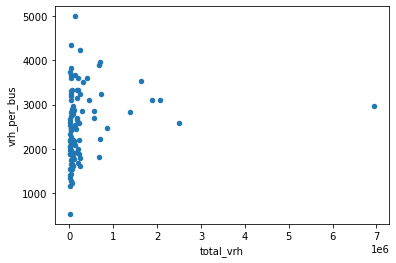

In [43]:
ntd_joined[['total_vrh', 'vrh_per_bus']].plot(x='total_vrh', y='vrh_per_bus', kind='scatter')

In [44]:
ntd_joined >> arrange(-_.vrh_per_bus)

,ntd_id,bus,artic_bus,otr_bus,dbl_deck_bus,trolleybus,Agency,total_vrh,total_buses,vrh_per_bus
39,90173,23,0,0,0,0,Transit Joint Powers Authority for Merced Coun...,114903,23,4995.782609
68,9R02-91047,9,0,0,0,0,Mendocino Transit Authority,39040,9,4337.777778
33,90211,55,0,0,0,0,Anaheim Transportation Network,232611,55,4229.290909
8,90031,173,0,0,0,0,Riverside Transit Agency,686321,173,3967.173410
12,90029,159,15,0,0,0,Omnitrans,676045,174,3885.316092
...,...,...,...,...,...,...,...,...,...,...
156,9R02-91058,6,0,0,0,0,City of Ojai,8041,6,1340.166667
48,9R02-91062,32,0,0,0,0,Eastern Sierra Transit Authority,40516,32,1266.125000
43,90205,46,0,0,0,0,City of Elk Grove,55961,46,1216.543478
28,9R02-91007,15,0,0,0,0,Fresno County Rural Transit Agency,17355,15,1157.000000


### Methodology notes

* filtered to buses
* all 2019 NTD data
* using 12 year useful life
* bus cost:
    * based on CARB Innovative Clean Transit cost model for a 40', 550kWh electric bus in 2022
    * Inclusive of charger and maintenance infrastructure upgrades, but not potential land aquisition costs for expanded facilities.

In [45]:
hours_by_operator

addl_service_hrs_annual
calitp_itp_id tract_type                         
4             rural                  0.000000e+00
              suburban               6.081400e+04
              urban                  3.315296e+06
10            rural                  2.219360e+04
11            rural                  1.142171e+05
...                                           ...
381           urban                  3.553689e+05
386           rural                  3.567200e+03
389           rural                  7.304873e+04
              suburban               2.150633e+04
473           rural                  3.244627e+04

[257 rows x 1 columns]

In [46]:
bus_cost = 776941 ## https://ww2.arb.ca.gov/resources/documents/transit-fleet-cost-model

In [47]:
median_vrh_per_bus = ntd_joined['vrh_per_bus'].median()

In [50]:
hours_by_operator['additional_buses'] = hours_by_operator['addl_service_hrs_annual'] / median_vrh_per_bus

In [51]:
hours_by_operator['bus_capex'] = hours_by_operator['additional_buses'] * bus_cost

In [52]:
hours_by_operator['bus_capex_annualized'] = hours_by_operator['bus_capex'] / 14 ## 14 year service life

In [53]:
hours_by_operator

addl_service_hrs_annual  additional_buses  \
calitp_itp_id tract_type                                              
4             rural                  0.000000e+00          0.000000   
              suburban               6.081400e+04         24.775853   
              urban                  3.315296e+06       1350.664256   
10            rural                  2.219360e+04          9.041756   
11            rural                  1.142171e+05         46.532491   
...                                           ...               ...   
381           urban                  3.553689e+05        144.778616   
386           rural                  3.567200e+03          1.453291   
389           rural                  7.304873e+04         29.760329   
              suburban               2.150633e+04          8.761761   
473           rural                  3.244627e+04         13.218731   

                             bus_capex  bus_capex_annualized  
calitp_itp_id tract_type                                      
4             rural       0.000000e+00          0.000000e+00  
              suburban    1.924938e+07          1.374955e+06  
              urban       1.049386e+09          7.495617e+07  
10            rural       7.024911e+06          5.017794e+05  
11            rural       3.615300e+07          2.582357e+06  
...                                ...                   ...  
381           urban       1.124844e+08          8.034603e+06  
386           rural       1.129121e+06          8.065151e+04  
389           rural       2.312202e+07          1.651573e+06  
              suburban    6.807372e+06          4.862408e+05  
473           rural       1.027017e+07          7.335839e+05  

[257 rows x 4 columns]

In [54]:
hours_by_operator.groupby('tract_type').sum()

,addl_service_hrs_annual,additional_buses,bus_capex,bus_capex_annualized
tract_type,,,,
rural,6.194919e+06,2523.833553,1.960870e+09,1.400621e+08
suburban,2.060605e+06,839.498194,6.522406e+08,4.658861e+07
urban,5.397544e+07,21989.796094,1.708477e+10,1.220341e+09


In [55]:
hours_by_operator.sum()

addl_service_hrs_annual    6.223096e+07
additional_buses           2.535313e+04
bus_capex                  1.969788e+10
bus_capex_annualized       1.406992e+09
dtype: float64

### Sandbox

In [ ]:
# tbl.transitstacks.provider_info() >> select(_.calitp_itp_id == _.itp_id, _.ntd_id) >> collect() >> inner_join(_, ntd_joined, on='ntd_id')